# Import

In [ ]:
import os
import glob
import shutil
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from os import listdir
from os.path import join
from random import shuffle
from numpy.core.records import array
from zipfile import ZipFile
from google.colab import drive
from xml.etree import ElementTree as ET
from PIL import Image

%matplotlib inline

# Download datasets

Copy kaggle.json from google drive

In [ ]:
shutil.copy("/content/drive/MyDrive/kaggle.json", "/content")

'/content/kaggle.json'

In [ ]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Dataset with 6k images

In [ ]:
!kaggle datasets download -d humansintheloop/medical-mask-detection

 99% 726M/733M [00:06<00:00, 92.8MB/s]
100% 733M/733M [00:06<00:00, 122MB/s] 


Dataset with people in mask and without it (863 images)

In [ ]:
!kaggle datasets download -d andrewmvd/face-mask-detection

 98% 390M/398M [00:03<00:00, 129MB/s]
100% 398M/398M [00:03<00:00, 123MB/s]


Dataset with mask and without it (12k)

In [ ]:
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

100% 330M/330M [00:02<00:00, 171MB/s]



# Unpack datasets

In [ ]:
def unpack_dataset(path:str, folder:str):
  """
  This function unpack dataset
  """
  zip = ZipFile(path)
  zip.extractall(folder)

In [ ]:
unpack_dataset("/content/medical-mask-detection.zip", "dataset_1")
unpack_dataset("/content/face-mask-detection.zip", "dataset_2")
unpack_dataset("/content/face-mask-12k-images-dataset.zip", "dataset_3")

# Visualisation

In [ ]:
def show_pictures(path_to_images:str):
  """
  Visualisation some pictures
  """
  # chose some pictures
  LIST_PIC = listdir(path_to_images)
  rand_pic = np.random.randint(0, len(LIST_PIC), 4)
  images_for_show = [LIST_PIC[rand_pic[0]], LIST_PIC[rand_pic[1]], LIST_PIC[rand_pic[2]], LIST_PIC[rand_pic[3]]]
  
  # create pic box for our pictures
  pic_box = plt.figure(figsize=(15,4))
  
  for i, picture in enumerate(images_for_show):
    picture = plt.imread(join(path_to_images, picture))
    pic_box.add_subplot(2,5,i+1)
    plt.imshow(picture)
    plt.axis('off')
  plt.show()

def show_pict_with_bounding_boxes(path_to_images:str, path_to_annotations:str):
  """
  This function show pictures with bounding boxes
  """
  ann = os.listdir(path_to_annotations)
  ann = ann[np.random.randint(0, len(ann))]
  extension = os.path.splitext(ann)[1]

  if extension == ".xml":
    xml_file = ET.parse(join(path_to_annotations, ann))
    root = xml_file.getroot()
    image = plt.imread(join(path_to_images, root[1].text))
    fig, ax = plt.subplots()
    
    for child in root:
      if child.tag == "object":
        for obj in child:
          if obj.tag == "bndbox":
            x_min     = int(obj[0].text)
            y_min     = int(obj[1].text)
            x_max     = int(obj[2].text)
            y_max     = int(obj[3].text)
            rectangle = patches.Rectangle([x_min, y_min], x_max - x_min, y_max - y_min, fill=False)
            ax.add_patch(rectangle)
    ax.imshow(image)

  elif extension == ".json":
    json_file = json.load(open(join(path_to_annotations, ann)))
    image = plt.imread(join(path_to_images, os.path.splitext(json_file["FileName"])[0] + ".jpg"))
    fig, ax = plt.subplots()
    ax.imshow(image)

    for attr in json_file["Annotations"]:
      rectangle = patches.Rectangle([attr["BoundingBox"][0], attr["BoundingBox"][1]], attr["BoundingBox"][2] - attr["BoundingBox"][0], attr["BoundingBox"][3] - attr["BoundingBox"][1], fill=False)
      ax.add_patch(rectangle)

  else:
    print("Такого расширений нет в списке")

Pictures from 1 dataset

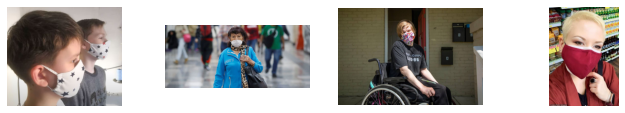

In [ ]:
show_pictures("/content/dataset_1/Medical mask/Medical Mask/images")

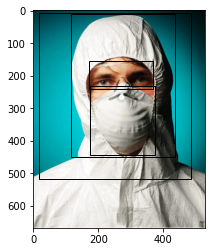

In [ ]:
show_pict_with_bounding_boxes("/content/dataset_1/Medical mask/Medical Mask/images", "/content/dataset_1/Medical mask/Medical Mask/annotations")

Pictures from 2 dataset

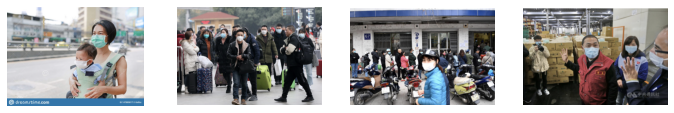

In [ ]:
show_pictures("/content/dataset_2/images")

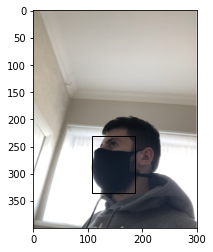

In [ ]:
show_pict_with_bounding_boxes("/content/dataset_2/images", "/content/dataset_2/annotations")

Pictures from 3 dataset

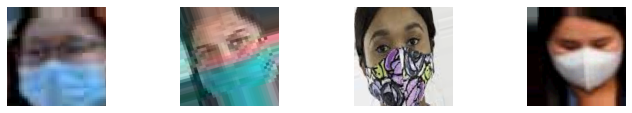

In [ ]:
show_pictures("/content/dataset_3/Face Mask Dataset/Train/WithMask")

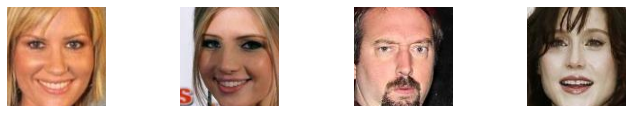

In [ ]:
show_pictures("/content/dataset_3/Face Mask Dataset/Train/WithoutMask")

# Create datasets from images

In [ ]:
folder_1 = "DATASET_1"
classes_1 = ["face_with_mask", "face_with_mask_incorrect", "face_no_mask"]
folder_2 = "DATASET_2"
classes_2 = ["with_mask", "mask_weared_incorrect", "without_mask"]

if not os.path.exists(folder_1):
  os.mkdir(folder_1)
  for c in classes_1:
    os.mkdir(join(folder_1, c))

if not os.path.exists(folder_2):
  os.mkdir(folder_2)
  for c in classes_2:
    os.mkdir(join(folder_2, c))

In [ ]:
def create_dataset(path_to_images:str, path_to_annotations:str, annotations_type:str=".json", list_of_classes:list=(), folder:str="Data", size_pic:list=(128, 128)) -> bool:
  """
  This function creates a dataset with classes that are in list_of_classes
  """
  global dictionary

  counter = 0
  connect_folders = lambda x: os.path.join(folder, x)
  dictionary = dict()
  successfully = 0
  unsuccessfully = 0
  all = len(listdir(path_to_images))

  if annotations_type == ".json":
    # json annotations
    for file in listdir(path_to_annotations):
      json_file = json.load(open(join(path_to_annotations, file)))
      img = Image.open(join(path_to_images, os.path.splitext(json_file["FileName"])[0] + ".jpg"))
      for attribute in json_file["Annotations"]:
        if attribute["classname"] in list_of_classes:
          # crop image
          img.crop(json_file["Annotations"][0]["BoundingBox"]).resize(size_pic).save(join(connect_folders(attribute['classname']), str(counter) + "_" + os.path.splitext(json_file["FileName"])[0] + "_.jpeg"))
          dictionary[str(counter) + ".jpeg"] = attribute["classname"]
          counter += 1
          successfully += 1
        else:
          unsuccessfully += 1
          pass
  elif annotations_type == ".xml":
    # xml annotations
    for file in os.listdir(path_to_annotations):
      xml_file = ET.parse(join(path_to_annotations, file))
      root = xml_file.getroot()
      img = Image.open(join(path_to_images, root[1].text))
      img = img.convert('RGB')

      for child in root:
        if child.tag == "object":
          for obj in child:
            if obj.tag == 'name':
              label = obj.text
              if not (obj.text in list_of_classes):
                pass
            if obj.tag == "bndbox":
              x_min     = int(obj[0].text)
              y_min     = int(obj[1].text)
              x_max     = int(obj[2].text)
              y_max     = int(obj[3].text)
              try:
                img.crop((x_min, y_min, x_max, y_max)).resize(size_pic).save(join(folder, label, str(counter) + ".jpeg"))
              except FileNotFoundError:
                unsuccessfully += 1
                pass
              counter += 1
              successfully += 1
        else:
          pass
  else:
    print("-_-")
    return False

  # next step we should to check uncorrect images 
  print("Check all files:\n")
  
  for cl in list_of_classes:
    for file in os.listdir(join(folder, cl)):
      try:
        im = Image.open(join(folder, cl, file))
        im.load()
      except:
        print(file)
        os.remove(join(folder, cl, file))
  print("{0} was successfully load and {1} was unsuccessfully of {2} images".format(successfully, unsuccessfully, all))
  return True

In [ ]:
create_dataset("/content/dataset_1/Medical mask/Medical Mask/images", "/content/dataset_1/Medical mask/Medical Mask/annotations", ".json", classes_1, folder_1, (150, 150))

Check all files:

9082 was successfully load and 14472 was unsuccessfully of 6017 images


True

In [ ]:
create_dataset("/content/dataset_2/images", "/content/dataset_2/annotations", ".xml", classes_2, folder_2, (150, 150))

Check all files:

4072 was successfully load and 0 was unsuccessfully of 853 images


True

# Count of images in clases of datasets

In [ ]:
def histogram_classes(path_to_classes):
  """
  Get path to classes and show histogram
  """
  x = [c for c in listdir(path_to_classes)]
  y = [len(listdir(join(path_to_classes, x[i]))) for i, c in enumerate(listdir(path_to_classes))]
  fig, ax = plt.subplots(1, 1)
  ax.bar(x, y)
  plt.show()

1 Dataset

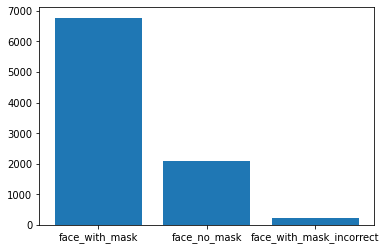

In [ ]:
histogram_classes("/content/DATASET_1")

2 Dataset

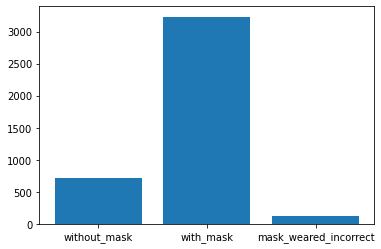

In [ ]:
histogram_classes("/content/DATASET_2")

3 Dataset

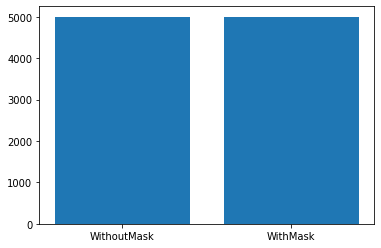

In [ ]:
histogram_classes("/content/dataset_3/Face Mask Dataset/Train")

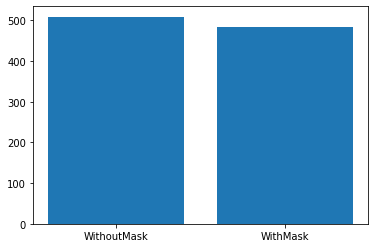

In [ ]:
histogram_classes("/content/dataset_3/Face Mask Dataset/Test")

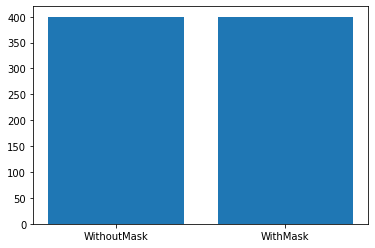

In [ ]:
histogram_classes("/content/dataset_3/Face Mask Dataset/Validation")

# Visualisation data again

How you see first dataset have an error inside json files

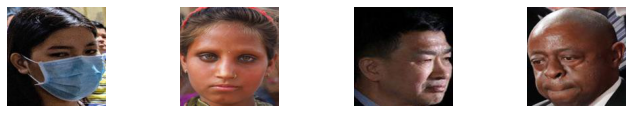

In [ ]:
show_pictures("/content/DATASET_1/face_no_mask")

Second dataset have a lot of people in bad quality

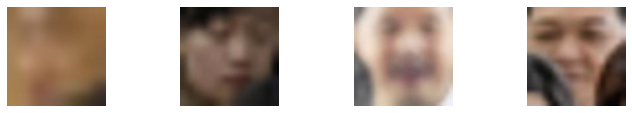

In [ ]:
show_pictures("/content/DATASET_2/without_mask")

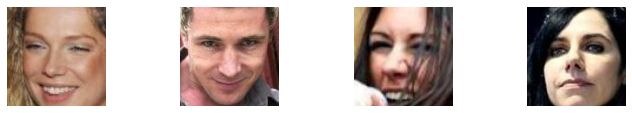

In [ ]:
show_pictures("/content/dataset_3/Face Mask Dataset/Test/WithoutMask")